# <center>CIFAR10 - Image Classification with Tensorflow & Keras
<br/><center><img src="files/keras-tensorflow-logo.jpg"></center>


## Part-1 - Creating the base model with Tensorflow

In this series, we will illustrate multi-class image classification for the CIFAR10 dataset using Convolution Neural Networks (CNNs). The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. Output classes defined are `['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog'. 'horse', 'ship', 'truck']`. You can download the image set for Python from [this link](https://www.cs.toronto.edu/~kriz/cifar.html). However, the Keras library already includes this dataset and I am going to load it from there.  

A good model/network, is one that generalizes well (i.e. performs well on data that it has not seen during training). With CNNs, indeed any deep network, the main problem is overfitting (and hence poor generalization). For a given network/model architecture, we can address overfitting my using regularization & increasing the size of the training data.

We will develop a progressively improving model with the following steps:
1. In **Part-1**: We'll develop a base-model. You'll notice that this model overfits and does not generalize well (i.e. accuracy score on test/validation data is poor compared to training data).
2. In **Part-2**: We'll add regularization (- we'll use L2 regularization &amp; dropout regularization) and batch normalization. You'll see that this improves the model's generalization somewhat.
3. In **Part-3**: We'll increase training data size artifically - we'll use image augmentation techniques to create an infinite stream of image batches with random transformations applied to each batch. You'll notice that adding image augmentation improves the model generalization further. We'll use Keras' `ImageDataGenerator()`class [see API](https://keras.io/preprocessing/image/#imagedatagenerator-class) for the same.

Each part has 2 associated IPython notebooks - one with the Keras code and the other with the Tensorflow code. 

**This is Part-1 (Tensorflow Version)** - you can jump directly to the [Keras version here](CIFAR10%20-%20Multiclass%20Classification%20-%20CNN%20-%20Tensorflow%20%26%20Keras-Part-1-Keras.ipynb) if you prefer to use Keras instead.

In this (Tensorflow) version, I provide a lot of convenience functions to build, train & evaluate our model as well as to predict outcomes. I also include code (not so robust, but workable!) of a Keras like progress bar that updates you of the progress as the Tensorflow model trains across epochs.

This workbook is divided into 4 broad sections:
+ [Helper functions](#helper_functions)
+ [Loading & Preprocessing Data](#loading_and_preprocessing)
+ [Building & Running our Tensorflow Model](#building_and_running_model)
+ [Predictions](#predictions)

<font color='scarlet'> I would encourage you to run these models on a machine with a GPU - I have run these on a _modest_ configuration (i5 CPU, Win10-64bit, 8GB RAM, 2GB Nvidea GPU). I have also run these on a CPU-only machine, but the models took very long to complete.</font>

In [1]:
# imports & tweaks
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, time
import tensorflow as tf

plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize'] = (8,6)
sns.set_style('darkgrid')
sns.set_context('talk')
sns.set_style({'font.sans-serif':['Verdana','Arial','Calibri','DejaVu Sans']})
%matplotlib inline

seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

### Helper Functions: 
<font color='scarlet'><b>WARNING:</b></font> Do not make any changes to these Helper functions, unless you are very sure about what you are doing. It may break the entire training/test code.
#### Generic Helper Functions <a name="helper_functions"/>

In [2]:
# a utility function that plots the losses and accuracies for training & validation sets across our epochs
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['acc'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['acc']
    val_acc_vals = history['val_acc']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

In [3]:
def print_time_taken(start_time, end_time):
    secs_elapsed = end_time - start_time
    
    SECS_PER_MIN = 60
    SECS_PER_HR  = 60 * SECS_PER_MIN
    
    hrs_elapsed, secs_elapsed = divmod(secs_elapsed, SECS_PER_HR)
    mins_elapsed, secs_elapsed = divmod(secs_elapsed, SECS_PER_MIN)
    
    if hrs_elapsed > 0:
        print('Time taken: %d hrs %d mins %d secs' % (hrs_elapsed, mins_elapsed, secs_elapsed))
    elif mins_elapsed > 0:
        print('Time taken: %d mins %d secs' % (mins_elapsed, secs_elapsed))
    elif secs_elapsed > 1:
        print('Time taken: %d secs' % (secs_elapsed))
    else:
        print('Time taken - less than 1 sec')

#### Tensorflow Model specific helper functions
Below are several utility functions created to ease the process of training Tensoflow CNN & ANN. Functions that begin with _ _ (double under-scores) are to be treated as 'internal' (or _private_) functions, which should not be called directly when training/testing models. You should use only the 'public' functions that don't begin with _ _.

In [4]:
tf_activation_fxns_map = {
    # covering most commonly used activation functions
    # please add to this as appropriate
    'relu' : tf.nn.relu,
    'elu' : tf.nn.elu,
    'sigmoid' : tf.nn.sigmoid,
    'tanh' : tf.nn.tanh,
    'leaky_relu' : tf.nn.leaky_relu
}

In [5]:
def conv2d(x, W, b, strides=1, padding='SAME', activation='relu'):
    """ creates a 2d convolution layer given a layer (x), weights (W) & biases (b), 
        strides (defaults=1) & padding(def 'SAME') """
    x = tf.nn.conv2d(x, W, strides=[1,strides,strides,1], padding=padding)
    x = tf.nn.bias_add(x, b)
    assert activation in tf_activation_fxns_map.keys()
    return tf_activation_fxns_map[activation](x)

In [6]:
def maxpool2d(x, pool_size=2, padding='VALID'):
    """ creates a max-pooling layer, with given pool_size (defaults to 2)"""
    return tf.nn.max_pool(x, ksize=[1, pool_size, pool_size, 1], 
                          strides=[1, pool_size, pool_size, 1], padding=padding)

In [7]:
def flatten(layer, weights_fc1):
    """ flattens out a layer before connecting to a dense layers 
        weights_fc1 = first fully connected layer
    """
    flt = tf.reshape(layer, [-1, weights_fc1.get_shape().as_list()[0]])
    return flt

In [8]:
def dense(x, W, b, activation='relu'):
    """ creates a dense (or fully connected) layer 
    @params:
        x - previous or input layer tensor
        W - weights Variable for this layer
        b - bias Variable for this layer
    @returns:
        tf.nn.relu(tf.matmul(x,W) + b)
    """
    dl = tf.add(tf.matmul(x, W), b)
    assert activation in tf_activation_fxns_map.keys()
    return tf_activation_fxns_map[activation](dl)

In [9]:
def __update_progbar(batch_num=None, num_batches=25, train_cost=None, train_acc=None, val_test_cost=None, 
                     val_test_acc=None, phase='train', final=False, eta=None):
        
    phase = phase.lower()
    if phase not in ['train','valid','eval','done']:
        raise ValueError('Unknown value for phase param - %s' % phase)
        
    phase_lookup = {
        'train' : 'Training',
        'valid' : 'Validating',
        'eval'  : 'Evaluating',
        'done'  : 'Completed!'
    }
    
    # ---------------------------------------------------------------------------
    # this is a helper function that displays a Keras-like progress bar as the
    # Tensorflow model does a batch training or testing
    # NOTE: this function is closely linked with batch_calc_loss_acc() function
    # and is not a very extensible function. Ideally, I should have implemented
    # a class with entry points for epoch_start/end batch_start/end etc.
    # Maybe next time :)
    # ---------------------------------------------------------------------------
    progbar_num_ticks = 25
    
    def get_prog_ticks(batch_num):
        # num_batchs <=> progbar_num_ticks 
        prog_tick = (batch_num  * progbar_num_ticks) // num_batches
        prog_tick = (1 if prog_tick <= 0 else prog_tick)
        bal_tick = (progbar_num_ticks - prog_tick)
        return prog_tick, bal_tick 
    
    def eta_str(eta):
        SECS_PER_MIN = 60
        SECS_PER_HR  = 60 * SECS_PER_MIN

        hrs_elapsed, secs_elapsed = divmod(eta, SECS_PER_HR)
        mins_elapsed, secs_elapsed = divmod(eta, SECS_PER_MIN)

        if hrs_elapsed > 0:
            return 'ETA: %dh %dm %ds - ' % (hrs_elapsed, mins_elapsed, secs_elapsed)
        elif mins_elapsed > 0:
            return 'ETA: %dm %ds - ' % (mins_elapsed, secs_elapsed)
        elif secs_elapsed > 1:
            return 'ETA: %ds - ' % (secs_elapsed)
        else:
            return 'ETA: <1s - '         
    
    len_num_batches = len(str(num_batches))
    
    if batch_num is None:
        # initial display only
        prog_bar = '  %s will commence shortly. Please wait...' % phase_lookup[phase]
    else:        
        prog_tick, bal_tick = get_prog_ticks(batch_num)

        if not final:
            # Training or Validating message
            prog_bar = '  %s : Batch (%*d/%*d) [%s%s%s] -> %sloss: %.4f - acc: %.4f%s' % \
                (phase_lookup[phase], len_num_batches, batch_num, len_num_batches, num_batches, 
                 ('='*(prog_tick-1)), '>', ('.'*(bal_tick)), 
                 (eta_str(eta) if eta is not None else ''),
                 train_cost, train_acc,' '*10)            
        else: # final display
            # it may not contain validation data
            if ((val_test_cost is None) or (val_test_acc is None)):
                prog_bar = '  %s Batch (%*d/%*d) [%s] -> loss: %.4f - acc: %.4f\n' % \
                    ((phase_lookup[phase] + ' :' if phase =='eval' else ''), len_num_batches, batch_num, 
                     len_num_batches, num_batches, 
                     ('='*(progbar_num_ticks)), train_cost, train_acc)                
            else:
                prog_bar = '  %s Batch (%*d/%*d) [%s] -> loss: %.4f - acc: %.4f - val_loss: %.4f - val_acc: %.4f\n' % \
                    ((phase_lookup[phase] + ' :' if phase =='eval' else ''), len_num_batches, batch_num, 
                     len_num_batches, num_batches, 
                     ('='*(progbar_num_ticks)), train_cost, train_acc, val_test_cost, val_test_acc)      
                                                    
    print(prog_bar, end='\r',flush=True)

In [10]:
def __batch_calc_loss_acc(sess, model, data, labels, batch_size, do_training=False, 
                          show_progbar=True, phase='train', final=False):
    
    # -------------------------------------------------------------------------------------------
    # batch calculates loss & accuracy using loss & accuracy 'attributes' of the model dict
    # batch calculations preclude OOM errors in Tensorflow - does not avoid them, but you could
    # tweak the batch size to almost eliminate them
    # NOTE: pass only a fitted Karas ImageDataGenerator with the karas_imagen parameter when using
    # image augmentation!!
    # --------------------------------------------------------------------------------------------
    
    num_batches = int(data.shape[0] / batch_size)
        
    train_op, cost, accuracy = model['train_op'], model['loss'], model['accuracy']

    loss, acc = 0.0, 0.0
        
    eta = None
    cum_time = 0.0

    for batch_num in range(num_batches):
        batch_start_time = time.time()
        x_train_batch = data[batch_num * batch_size : min((batch_num+1) * batch_size,len(data))]
        y_train_batch = labels[batch_num * batch_size : min((batch_num+1) * batch_size, len(labels))]
            
        feed_dict = {X:x_train_batch, y:y_train_batch}
            
        if do_training:
            # run a training op & update weights
            sess.run(train_op, feed_dict=feed_dict)
        
        # calculate batch loss & accuracy
        train_loss_batch, train_acc_batch = sess.run([cost, accuracy], feed_dict=feed_dict)
        loss += (batch_size * train_loss_batch)
        acc += (batch_size * train_acc_batch)
        batch_end_time = time.time()
           
        # Calculate ETA: We calculate average time per step so far & extrapolate
        cum_time += (batch_end_time - batch_start_time)
        time_per_batch = cum_time / (batch_num + 1)
        batches_remaining = num_batches - (batch_num + 1)
        eta = time_per_batch * batches_remaining
        
        if show_progbar:
            __update_progbar(batch_num=batch_num+1, num_batches=num_batches, train_cost=train_loss_batch, 
                             train_acc=train_acc_batch, phase=phase, final=final, eta=eta)    

    loss /= data.shape[0]
    acc /= data.shape[0]   
        
    return loss, acc

In [11]:
def __batch_run_model(sess, model, train_data, train_labels, num_epochs=10, batch_size=32,  
                      validation_data=None, do_training=True, show_progbar=True):
    
    # note validation_data is a tuple (val_data, val_labels)
    history_val = {
        'loss' : [],
        'acc' : [],   
        'val_loss' : [],
        'val_acc' : []
    }
    history_no_val = {
        'loss' : [],
        'acc' : [],   
    }
    
    val_data, val_labels = None, None
    
    if validation_data is not None:
        if type(validation_data) is not tuple:
            raise ValueError('Invalid data type: The validation_data parameter must be a tuple or None!')
        else:
            val_data, val_labels = validation_data
    
    history = (history_no_val if validation_data is None else history_val)
    validating = (False if validation_data is None else True)
    num_batches = int(train_data.shape[0] / batch_size)    
    
    if do_training:
        if validating:
            print('Train on %d samples, validate with %d samples. Train for %d epochs, with %d batches per epoch.' % \
                  (len(train_data), len(val_data), num_epochs, num_batches))
        else:
            print('Train on %d samples. Train for %d epochs,, with %d batches per epoch.' % \
                  (len(train_data), num_epochs, num_batches))            
    
    for epoch in range(num_epochs):
        if num_epochs > 1: 
            print('Epoch %d/%d:' % (epoch+1, num_epochs))

        phase_x = ('train' if do_training else 'eval')
        # calculate loss & accuracy on training data set
        train_loss, train_acc = __batch_calc_loss_acc(sess, model, train_data, train_labels, batch_size, 
                                                      do_training=do_training, show_progbar=show_progbar, 
                                                      phase=phase_x, final=False)

        if validating:
            # compute costs & accuracies on validation sets if we are also validating
#             __update_progbar(batch_num=num_batches, num_batches=num_batches, train_cost=train_loss,
#                              train_acc=train_acc, phase='valid', final=False)  
            
            val_loss, val_acc = __batch_calc_loss_acc(sess, model, val_data, val_labels, 
                                                      np.minimum(val_data.shape[0],batch_size), 
                                                      do_training=False, show_progbar=True, 
                                                      phase='valid', final=False)
            
            __update_progbar(batch_num=num_batches, num_batches=num_batches, train_cost=train_loss,
                             train_acc=train_acc, val_test_cost=val_loss, val_test_acc=val_acc, phase=phase_x, 
                             final=True)
            sys.stdout.flush()
            history['loss'].append(train_loss)
            history['acc'].append(train_acc)    
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
        else:
            __update_progbar(batch_num=num_batches, num_batches=num_batches, train_cost=train_loss,
                             train_acc=train_acc, phase= phase_x, final=True)
            sys.stdout.flush()
            history['loss'].append(train_loss)
            history['acc'].append(train_acc)    
            
        #print('', flush=True)
    
    return history

In [12]:
def __batch_run_predict(sess, model, data, batch_size):
    num_batches = np.maximum(int(data.shape[0] / batch_size),1)
    predictions = []
    
    out = model['out']
    
    for batch_num in range(num_batches):
        # grab the Nth batch
        x_batch = data[batch_num * batch_size : min((batch_num+1) * batch_size,len(data))]
        pred = sess.run(out, feed_dict={X:x_batch})
        predictions.extend(pred.tolist())
    
    return np.array(predictions)

In [13]:
def train_model(sess, model, data, labels, num_epochs=10, batch_size=32,validation_split=None, 
                validation_data=None):
    """
    trains the model on data & labels and cross-validates on validation_data, if provided. The
    model is run through batch gradient descent, using a batch size = batch_size (=32 by default)
    for num_epochs (=10 by default) epochs.
    @params:
        - sess: Tensorflow Session() object 
        - model: The Tensorflow model, built elsewhere. The model is expected to have named
            attributes 'train_op', 'loss', 'accuracy' etc. defined
        - data & labels: training data & labels
        - num_epochs: number of epochs through which training is run (optional, default = 10)
        - batch_size: number of records that will be randomly drawn from data & labels and fed as a
            batch to the training operation (optional, default = 32)
        - validation_split: fraction (floating point value) of the training data that must be set aside as the 
            validation data (optional). E.g. if validation_split=0.1, then 10% of the data & labels (training set)
            is randomly set aside as validation data & balance 90% is used as the training set.
        - validation_data: a tuple of (val_data, val_labels) that define the validation set against which
          the model will cross-validate (optional). You can use this INSTEAD of using validation_split.
            
            NOTE: 
            - use either validation_data or validation_split. If BOTH are used than validation_split is given
              preference & validation_data is ignored.
            - it is always a good idea to shuffle the training/validation data before calling this function, unless
              data must be in some sequence!
    """

    if validation_split is not None:
        num_val_recs = int(validation_split * data.shape[0])
        # set-aside num_val_recs as validation set from data, rest is data
        val_data = data[:num_val_recs]
        val_labels = labels[:num_val_recs]
        data2 = data[num_val_recs:]
        labels2 = labels[num_val_recs:]

        history = __batch_run_model(sess, model, data2, labels2, num_epochs, batch_size,
                                    validation_data=(val_data, val_labels), do_training=True, 
                                    show_progbar=True)
    else:
        history = __batch_run_model(sess, model, data, labels, num_epochs, batch_size,
                                    validation_data, do_training=True, show_progbar=True)

    return history

In [14]:
def evaluate_model(sess, model, data, labels, batch_size=32):
    """ use only to evalute model's against test data """
    history = __batch_run_model(sess, model, data, labels, num_epochs=1, batch_size=batch_size, 
                                do_training=False, show_progbar=True, validation_data=None)
    avg_loss, avg_acc = np.mean(history['loss']), np.mean(history['acc'])
    return (avg_loss, avg_acc)

In [15]:
def predict(sess, model, data):
    """ predict the output classes - will return 1 output value per row of data """
    predictions = __batch_run_predict(sess, model, data, batch_size=np.minimum(data.shape[0],32))
    return np.argmax(predictions, axis=1)

In [16]:
def predict_probs(sess, model, data):
    """ predict the output class probabilities - will return an array with shape (data.shape[0], num_classes)"""
    predictions = __batch_run_predict(sess, model, test_data, batch_size=np.minimum(data.shape[0],32))
    # convert log values to probabilities - take inverse logs
    probabilities = sess.run(tf.nn.softmax(predictions))              
    return np.argmax(predictions, axis=1), probabilities

### Loading & Preprocessing Data <a name='loading_and_preprocessing' />

I am going to load the MNIST dataset from the `keras.datasets` library using the `karas.datasets.cifar10.load_data()` function, which loads the CIFAR-10 dataset and conveniently returns two pairs of tuples for training & test datasets. This call will download data from the cs.toronto.edu website the very first time you run it. The images are re-shaped correctly as (num_samples, 32, 32, 3) & labels (num_samples, 1). However, the image data is not normalized and labels are not one-hot-encoded, which is what we will do in data preprocessing.

In [17]:
from keras.datasets.cifar10 import load_data
from keras.utils import to_categorical

Using TensorFlow backend.


In [18]:
(train_data, train_labels), (test_data, test_labels) = load_data()
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

Notice that we have 50,000 images in the training set & 10,000 images in the test set. We have 10 catrgories of output labels - unlike the MNIST dataset, where they were values for numbers, here we have 10 distinct types.

Label Values & Descriptions: 
* 0 - Airplane
* 1 - Automobile
* 2 - Bird
* 3 - Cat 
* 4 - Deer 
* 5 - Dog 
* 6 - Frog 
* 7 - Horse 
* 8 - Ship 
* 9 - Truck

Let us view how some of the images look - we will randomly pick 20 images from the `train_digits` set. First, let us create a dict that will help us decode the label values to text.

In [19]:
# need to look at labels again
cifar10_labels = {
    0 : 'Airplane', 
    1 : 'Automobile', 
    2 : 'Bird', 
    3 : 'Cat', 
    4 : 'Deer', 
    5 : 'Dog', 
    6 : 'Frog', 
    7 : 'Horse', 
    8 : 'Ship', 
    9 : 'Truck'    
}

In [20]:
rand_20 = np.random.randint(0, train_data.shape[0],20)
sample_data = train_data[rand_20]
sample_labels = train_labels[rand_20].ravel()

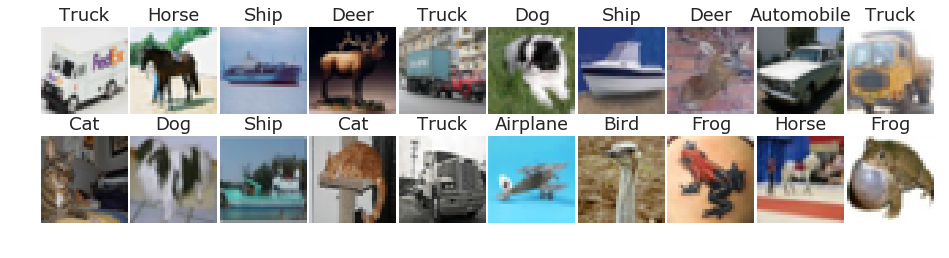

In [21]:
row_count, col_count = 2, 10
f, ax = plt.subplots(row_count, col_count, figsize=(16,4), gridspec_kw={'wspace':0.03, 'hspace':0.01}, squeeze=True)
for r in range(row_count):
    for c in range(col_count):
        image_index = r * col_count + c
        ax[r,c].axis("off")
        ax[r,c].imshow(sample_data[image_index])
        ax[r,c].set_title(cifar10_labels[sample_labels[image_index]])
plt.show()
plt.close()

**Data Pre-processing:** We need to pre-process our image & labels data for consumption by our CNN.
* As the `load_data()` function has already returned the image & labels data in the correct shapes viz. training data -> Image shape: `(50000, 32, 32, 3)`, labels shape: `(50000,1)`; test data -> Image shape: `(10000, 32, 32, 3)`, labels shape: `(10000,1)`, **we can skip reshaping our image & label arrays**.
* However, **the image data needs to be re-scaled** - we will convert image date to `float` type & divide by `255.0`, so all pixels have values between `0.0` & `1.0`.
* Finally, **the image labels need to be one-hot-encoded** (as we have 10 classes) - we will use Keras' `to_categorical()` function to help us with this.

In [22]:
image_height, image_width = train_data.shape[1], train_data.shape[2]
num_channels = 3 # as we have color images
input_shape = image_height * image_width * num_channels
image_height, image_width, num_channels, input_shape

(32, 32, 3, 3072)

In [23]:
# # normalize the images - between 0.0 & 1.0
# train_data = train_data.astype('float32') / 255.
# test_data = test_data.astype('float32') / 255.

# mean normalize the data (i.e. z-scores)
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

# mean normalize the images by calculating the mean & stdev of the test images
# along all 4 axes and then finding the z-scores for train & test images using 
# these values.

mean = np.mean(train_data,axis=(0,1,2,3))
std = np.std(train_data,axis=(0,1,2,3))
train_data = (train_data-mean)/(std)
test_data = (test_data-mean)/(std)

In [24]:
# one-hot-encode the labels - so 3 becomes [0 0 0 1 0 0 0 0 0 0] & so on...
num_classes = 10
train_labels_cat = to_categorical(train_labels,num_classes)
test_labels_cat = to_categorical(test_labels,num_classes)
train_labels_cat.shape, test_labels_cat.shape

((50000, 10), (10000, 10))

In [25]:
train_data.shape, train_labels_cat.shape, test_data.shape, test_labels_cat.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

Perfect!

Following steps outline our training & evaluation methodology:
* Shuffle the training data & labels, so as to rid it of any sort of ordering it may have (not required for test data).
* Set aside 10% of the _training_ data & labels as _validation_ set (data & labels) - since we have shuffled the training data, we could choose the first 10% of records as the validation set & the rest as the training set.
* Our CNN will be trained _strictly_ on the training data _only_ & _cross-validated_ on the validation set - for training, we will put the model through `num_epochs` epochs and use batch gradient descent, with a batch-size of `num_batches` - these are hyper-parameters that we define before training our model.
* As the model trains, we will calculate the average loss & accuracies per epoch on the training & validation sets - these will then be plotted (loss vs epochs and accuracies vs epochs) to assess how our model is bahaving.
* Finally we will test the model with test data, which the model has _never seen_ during training.

As good test score will mean that the model is generalizing well. A poor score means that it needs improvement.

**NOTE:** for a complex problem, like classification of colored images, we don't really have sufficient training data. So at the very outset, I am expecting _poor_ test scores!

In [26]:
# shuffle the training dataset & set aside val_perc % of rows as validation data
for _ in range(5): 
    indexes = np.random.permutation(len(train_data))

# randomly sorted!
train_data = train_data[indexes]
train_labels_cat = train_labels_cat[indexes]

# now we will set-aside val_perc% of the train_data/labels as cross-validation sets
val_perc = 0.10
val_count = int(val_perc * len(train_data))

# first pick validation set
val_data = train_data[:val_count,:]
val_labels_cat = train_labels_cat[:val_count,:]

# leave rest in training set
train_data2 = train_data[val_count:,:]
train_labels_cat2 = train_labels_cat[val_count:,:]

train_data2.shape, train_labels_cat2.shape, val_data.shape, val_labels_cat.shape, test_data.shape, test_labels.shape

((45000, 32, 32, 3),
 (45000, 10),
 (5000, 32, 32, 3),
 (5000, 10),
 (10000, 32, 32, 3),
 (10000, 1))

In [27]:
# some globals, used across Tensorflow & Keras models
num_features = train_data.shape[1]
num_epochs = 15
batch_size = 100
kernel_size = 3
pool_size = 2
strides = 1

### Building & Running our Tensorflow Model <a name="building_and_running_model" />

In this section we will create the base model with Tensorflow APIs and train it against our train/validation sets. We use the following config:
* 4 Conv2D layers with 32, 64, 128, 128 filters - each layer with strides = 1 & padding='SAME' and `relu()` activation (see `conv2d()`).
* A MaxPooling2D layer immediately after each Conv2D layer, with pool_size=2. So 4 MaxPooling2D layers, each of which will reduce the image dimension by 2
* **NOTE**: After 4 MaxPooling2D layers, we end up with a 2 x 2 image.
* Flatten out the output of the last Conv2D + MaxPool2D _layer_ before feeding into the densly connected layers.
* 1 densly connected (of fully connected) layer with 512 nodes & relu activations
* Output layer with 10 (num_classes) nodes
* Since this is a multi-class classification problem, we will use `softmax cross-entropy` as cost/loss function
* We will use the `RMSProp optimizer` with `learning rate = 0.001`
* I have provided several convenient functions for building the model - there are functions to create weights & biases, build the model, train the model, evaluate the model and finally generate the predictions & prediction probabilities.

But first, let us create some place holders, which we will use to pass in data to our Tensorflow model.

In [28]:
X = tf.placeholder(tf.float32, [None, image_height, image_width, num_channels], name='X')
y = tf.placeholder(tf.float32, [None, num_classes], name='y')

In [29]:
def init_cnn_weights_and_biases(image_shape, num_classes, conv_filters, num_maxpools, dense_nodes, kernel_size=3):
    # create a dict of weights & biases like the "expanded version below"
    # NOTE: All conv layer weights have keys wcXX & bcXX, and all dense layers have keys wdYY & bdYY
    # where XX is an integer from 1..len(conv_filters) and YY is an integer from 1..len(dense_nodes)
    # conv_filters - Python list where elements = # of filters per conv layer
    # dense_nodes - Python list where elements = # of nodes per fully-connected (or Dense) layer
    
    # split the input_shape into individual dimensions of image
    image_height, image_width, num_channels = image_shape
    
    # initializer for the weights - for biases we'll use np.zeros()
    initializer =  tf.contrib.layers.xavier_initializer()
    
    weights, biases = {}, {}
    
    # add weights & biases for convolutional layers
    cnn0 = num_channels
    for i, cnn1 in enumerate(conv_filters):
        wname = 'wc%d' % (i+1)
        bname = 'bc%d' % (i+1)
        weights[wname] = tf.Variable(initializer([kernel_size, kernel_size, cnn0, cnn1]), name=wname)
        biases[bname] = tf.Variable(tf.zeros([cnn1]), name=bname)
        cnn0 = cnn1
    
    # reduce the image dimension by 2 for evary maxpool2d layer
    im_h, im_w = image_height, image_width
    for _ in range(num_maxpools):
        im_h //= 2
        im_w //= 2
        
    assert (im_h > 0) and (im_w > 0)
    
    # add weights & biases for dense layers
    dnn0 = im_h * im_w * cnn0
    for i, dnn1 in enumerate(dense_nodes):
        wname = 'wd%d' % (i+1)
        bname = 'bd%d' % (i+1)
        weights[wname] = tf.Variable(initializer([dnn0, dnn1]), name=wname)
        biases[bname] = tf.Variable(tf.zeros([dnn1]), name=bname)
        dnn0 = dnn1
        
    # add the weights & biases for output layer
    weights['out'] = tf.Variable(initializer([dnn0, num_classes]), name='w_out')
    biases['out'] = tf.Variable(initializer([num_classes]), name='b_out')
    return weights, biases

In [30]:
def build_tf_cnn_model(X, y, image_shape, num_classes):
    
    """
    convenience function to build a CNN model using the API defined above
        @params:
            - X, y - placeholder tensors to pass batch data into the conv-net
            - image_shape - tuple of format (image_height, image_width, num_channels) that describes 
                 shape of an input image
            - num_classes - number of output classes (2 for binary, N for multi-class with N outcomes)
            - kernel_size (integer, optional, default=3) - size of the kernel that convolves over images
               (e.g. for kernel_size=3, we use a 3x3 kernel for convolutions)
            - pool_size (integer, optional, default=2) - size of the max-pooling window
               (e.g. for pool_size=2, the CNN uses a 2x2 max-pooling window)        
            - strides (integer, optional, default=1) - size of the stride in x & y direction
            - padding (string, optional, default='SAME') - one of 'SAME' or 'VALID' 
    """
   # create Variables for weights & biases ------------------------------------------------------------
    conv_filters = [32, 32, 64, 64, 128, 128]
    num_maxpools = 3
    dense_nodes  = [512]
    weights, biases = init_cnn_weights_and_biases(image_shape, num_classes, conv_filters, 
                                                  num_maxpools, dense_nodes, kernel_size=3)
    
    # API for reference...
    # def conv2d(x, W, b, strides=1, padding='SAME', activation='relu', batch_normalize=False):
    # def maxpool2d(x, pool_size=2, padding='VALID'):
    # def flatten(layer, weights_fc1):
    # def dense(x, W, b, activation='relu', batch_normalize=False):
    
   # build out the network --------------------------------------------------------------------------
    # conv2d layers + maxpool2d layers
    conv1 = conv2d(X, weights['wc1'], biases['bc1'], strides=1, padding='SAME', activation='elu')
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'], strides=1, padding='SAME', activation='elu')
    mp1 = maxpool2d(conv2, pool_size=2)
    
    conv3 = conv2d(mp1, weights['wc3'], biases['bc3'], strides=1, padding='SAME', activation='elu')
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'], strides=1, padding='SAME', activation='elu')
    mp2 = maxpool2d(conv4, pool_size=2)
    
    conv5 = conv2d(mp2, weights['wc5'], biases['bc5'], strides=1, padding='SAME', activation='elu')
    conv6 = conv2d(conv5, weights['wc6'], biases['bc6'], strides=1, padding='SAME', activation='elu')
    mp3 = maxpool2d(conv6, pool_size=2)    
    
    # flatten
    fc0 = flatten(mp3, weights['wd1'])
    
    # fully-connected (dense) layer(s)
    fc1 = dense(fc0, weights['wd1'], biases['bd1'], activation='relu')
        
    # output layer
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    
  # other tensors required to "complete" the network  
    # we will use softmax-crossentropy cost as this is a multiclass classification problem
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=out))
    # RMSProp optimizer - as network arch is a little complex, using a small learning rate
    optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(cost)
    correct_prediction = tf.equal(tf.argmax(out,axis=1), tf.argmax(y, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))        
    
  #  now collect all these tensors & operators into a dict, which we can conveniently pass around
  #  to the various utility functions we have created above
  #  NOTE: keys of the dicts must be names EXACTLY as shown below, else the helper functions won't work.
    model = {}
    model['weights'] = weights
    model['biases'] = biases
    model['out'] = out
    model['loss'] = cost
    model['optimizer'] = optimizer
    model['train_op'] = train_op
    model['correct_prediction'] = correct_prediction
    model['accuracy'] = accuracy
    return model    

Create the base model & train it on our training + validation data for `num_epoch` epochs & `batch_size` batches, which we defined as global variables above.

In [31]:
# build the tensorflow model
image_shape = (image_height, image_width, num_channels)
tf_base_model = build_tf_cnn_model(X, y, image_shape, num_classes)
tf_base_model

{'weights': {'wc1': <tf.Variable 'wc1:0' shape=(3, 3, 3, 32) dtype=float32_ref>,
  'wc2': <tf.Variable 'wc2:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
  'wc3': <tf.Variable 'wc3:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
  'wc4': <tf.Variable 'wc4:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
  'wc5': <tf.Variable 'wc5:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
  'wc6': <tf.Variable 'wc6:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
  'wd1': <tf.Variable 'wd1:0' shape=(2048, 512) dtype=float32_ref>,
  'out': <tf.Variable 'w_out:0' shape=(512, 10) dtype=float32_ref>},
 'biases': {'bc1': <tf.Variable 'bc1:0' shape=(32,) dtype=float32_ref>,
  'bc2': <tf.Variable 'bc2:0' shape=(32,) dtype=float32_ref>,
  'bc3': <tf.Variable 'bc3:0' shape=(64,) dtype=float32_ref>,
  'bc4': <tf.Variable 'bc4:0' shape=(64,) dtype=float32_ref>,
  'bc5': <tf.Variable 'bc5:0' shape=(128,) dtype=float32_ref>,
  'bc6': <tf.Variable 'bc6:0' shape=(128,) dtype=float32_ref>,
  'bd1': <tf.Variable 'bd1:0' shape=(512

Create a Tensorflow session & train the model - the `train_model()` call will return a dict object, holding Python lists of training & validation losses & accuracies per epoch.

In [32]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
start_time = time.time()
history = train_model(sess, tf_base_model, train_data2, train_labels_cat2, num_epochs=15, 
                      batch_size=100,validation_data=(val_data, val_labels_cat))
end_time = time.time()
print_time_taken(start_time, end_time)

Train on 45000 samples, validate with 5000 samples. Train for 15 epochs, with 450 batches per epoch.
Epoch 1/15:
   Batch (450/450) [=========================] -> loss: 1.1242 - acc: 0.6299 - val_loss: 1.0041 - val_acc: 0.6550
Epoch 2/15:
   Batch (450/450) [=========================] -> loss: 0.3073 - acc: 0.9319 - val_loss: 0.8395 - val_acc: 0.7246
Epoch 3/15:
   Batch (450/450) [=========================] -> loss: 0.1140 - acc: 0.9816 - val_loss: 0.8955 - val_acc: 0.7434
Epoch 4/15:
   Batch (450/450) [=========================] -> loss: 0.0539 - acc: 0.9898 - val_loss: 1.1064 - val_acc: 0.7434
Epoch 5/15:
   Batch (450/450) [=========================] -> loss: 0.0320 - acc: 0.9926 - val_loss: 1.2707 - val_acc: 0.7514
Epoch 6/15:
   Batch (450/450) [=========================] -> loss: 0.0226 - acc: 0.9950 - val_loss: 1.4183 - val_acc: 0.7294
Epoch 7/15:
   Batch (450/450) [=========================] -> loss: 0.0193 - acc: 0.9951 - val_loss: 1.6048 - val_acc: 0.7430
Epoch 8/15:
   Ba

**Observation & Interpretation:** 
* We can see that the model achieves a training accuracy of ~99%, but the struggles to get above 74% for validation accuracy (see `acc` and `val_acc` columns in the output above). 
* This is indicative of an overfitting model - a model that has learnt the data patterns of the training set very well, but does not generalize well.

Let's plot the test & validation losses vs epochs and test & validation accuracies vs epochs. Conveniently the `history` returned by the `train_model(...)` call encapsulates all the losses & accuracy values across epochs; and the provided `show_plots()` function plots out neat graphs in a 1 x 2 grid.

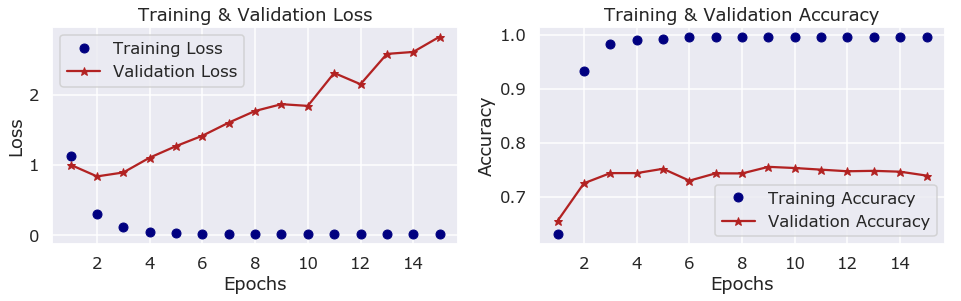

In [33]:
show_plots(history)

**Observations from graphs:** There you go. A tell-tale behavior of an overfitting model.
+ On the top-left we are plotting training & validation loss vs epochs - we can see that the training loss falls smoothly towards zero. However the validation loss falls for a few epochs (~2-3) and then rises(!).
+ On the top-right we are plotting the training & validation accuracies vs epochs - we can see that the training accuracy rises across epochs and approachs 1. However, the validation accuracy flattens out after a few epochs (~3-4) - it appears to be flattening around 74%.
+ This means that the model has started overfitting our training images after ~6 epochs. Training for more epochs is not going to improve validation performance (we should be interested in validation accuracy more than training accuracy!).

**Next, and very important, let us see how our model performs against test data** - recall that the model has not seen this data before (during the entire training process). Considering that the model fared poorly on validation data, I don't expect a good test accuracy score - it should be around 71%, the same value around which the validation accuracy curve started to flatten out at. Let's call the `evaluate_model()` function passing in test data - this functions does a batch run on training data for 1 epoch & reports the loss & accuracy as a tuple.

In [34]:
test_loss, test_acc = evaluate_model(sess, tf_base_model, test_data, test_labels_cat, batch_size)
print('Testing -> loss: %.3f accuracy: %.3f' % (test_loss, test_acc))

  Evaluating : Batch (100/100) [=========================] -> loss: 2.8479 - acc: 0.7329acc: 0.7000          
Testing -> loss: 2.848 accuracy: 0.733


Ok, we got ~73% test accuracy - this is a bad score as expected.

Our model is not generalizing well at all - this is to be expected as we simply don't have enough images to train our image classifier on. Let's run some preductions on the model & see how it fares - again, I expect a lot of errors. We'll randomly pick 20 images from the test dataset & predict the outcomes & compare them to the actuals. We'll also predict the probabilities of each output class & view the top 3 predictions that our model came up with.

### Predictions <a name="predictions"/>

In [35]:
# let's pick 20 random values from the test data
rand_idx = np.random.randint(0, test_data.shape[0],20)
test_images = test_data[rand_idx]
test_labels_act = test_labels_cat[rand_idx]

In [36]:
# Actuals - we need to 'one-hot-decode' these
y_true = np.argmax(test_labels_act, axis=1)
y_true

array([5, 7, 1, 4, 9, 3, 5, 7, 3, 4, 7, 5, 5, 2, 4, 4, 0, 6, 7, 5])

In [37]:
# predictions
y_pred = predict(sess, tf_base_model, test_images)
y_pred

array([5, 7, 1, 4, 9, 6, 5, 7, 3, 4, 7, 5, 3, 2, 4, 7, 0, 6, 7, 5])

Quickly eye-balling the above results, we can see quite a few incorrect predictions. Next, let's examine the top 3 predictions of our model.

In [38]:
def show_predictions(sess, model, data, one_hot_labels, label_names=None, top_n=3):
    
    """ for every row in the data/labels set, it shows the actual label, predicted label and the 
        top_n predictions of the model """
    def decode_topn(pred_pairs, label_names, top_n):
        #[(6, 4, [(4, 0.99946624), (3, 0.00046321715), (6, 6.602875e-05)])
        assert len(pred_pairs) == top_n
        result = ''
        for i in range(top_n):
            result += '(%d%s:%.5f) ' % (pred_pairs[i][0], 
                                (' [' + label_names[pred_pairs[i][0]] + ']' if label_names is not None else ''),
                                 pred_pairs[i][1])
        return result    
        
    y_true = np.argmax(one_hot_labels, axis=1)
    #def predict_probs(sess, model, data, batch_size=1):
    y_pred, pred_probs = predict_probs(sess, model, data)
    #y_pred = np.argmax(pred_probs, axis=1)
    
    # display grid of images with labels - NOTE: we have mean scaled the images, so they will not look the same
    # as the original images
    row_count, col_count = 2, 10
    f, ax = plt.subplots(row_count, col_count, figsize=(16,4), gridspec_kw={'wspace':0.03, 'hspace':0.01}, squeeze=True)
    for r in range(row_count):
        for c in range(col_count):
            image_index = r * col_count + c
            ax[r,c].axis("off")
            ax[r,c].imshow(data[image_index])
            ax[r,c].set_title(cifar10_labels[y_true[image_index]])
    plt.show()
    plt.close()
    
    results = []
    
    for i, _ in enumerate(y_true):
        true_class_i = y_true[i]
        pred_class_i = y_pred[i]
        # for the ith prediction
        pred_pairs_i = [(cls, pred_probs[i][cls]) for cls, _ in enumerate(pred_probs[i])]
        pred_pairs_i = sorted(pred_pairs_i, key=lambda t: t[1], reverse=True)
        results.append((true_class_i, pred_class_i, pred_pairs_i[:top_n]))
                       
    # above block will return a list, with each entry as below
    # [(true_class_0, pred_class_0,[(4,0.98),(2,0.36),(0,0.15)]),
    #  (true_class_1, pred_class_1, [(6,0.65),(0,0.45),(1,0.23)]),...]

    assert len(results) == len(y_true)
                              
    # display formatted results
    for i in range(len(y_true)):
        #print(decode_topn(results[i][2]))
        print('A: %d%s P: %d%s Top:%s' % \
               (results[i][0], (' (' + label_names[results[i][0]] + ')' if label_names is not None else ''),
                results[i][1], (' (' + label_names[results[i][1]] + ')' if label_names is not None else ''),
                decode_topn(results[i][2], label_names, top_n))
             )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

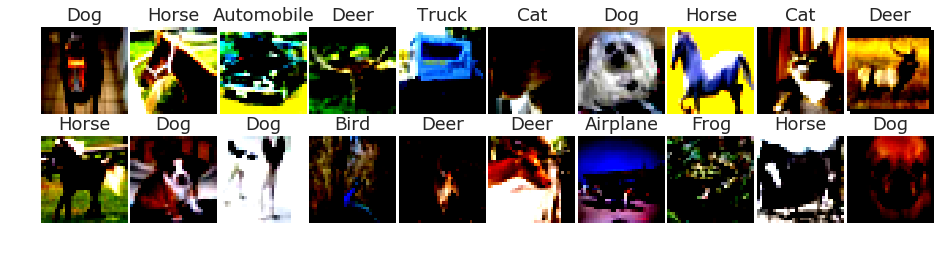

A: 5 (Dog) P: 3 (Cat) Top:(3 [Cat]:0.69492) (5 [Dog]:0.30508) (8 [Ship]:0.00000) 
A: 7 (Horse) P: 8 (Ship) Top:(8 [Ship]:0.99998) (1 [Automobile]:0.00002) (0 [Airplane]:0.00000) 
A: 1 (Automobile) P: 0 (Airplane) Top:(0 [Airplane]:0.91530) (3 [Cat]:0.08212) (8 [Ship]:0.00229) 
A: 4 (Deer) P: 1 (Automobile) Top:(1 [Automobile]:0.66054) (8 [Ship]:0.18334) (0 [Airplane]:0.15612) 
A: 9 (Truck) P: 4 (Deer) Top:(4 [Deer]:1.00000) (6 [Frog]:0.00000) (3 [Cat]:0.00000) 
A: 3 (Cat) P: 6 (Frog) Top:(6 [Frog]:0.99623) (5 [Dog]:0.00377) (4 [Deer]:0.00000) 
A: 5 (Dog) P: 1 (Automobile) Top:(1 [Automobile]:0.64421) (3 [Cat]:0.35578) (9 [Truck]:0.00000) 
A: 7 (Horse) P: 6 (Frog) Top:(6 [Frog]:1.00000) (9 [Truck]:0.00000) (5 [Dog]:0.00000) 
A: 3 (Cat) P: 3 (Cat) Top:(3 [Cat]:1.00000) (5 [Dog]:0.00000) (4 [Deer]:0.00000) 
A: 4 (Deer) P: 1 (Automobile) Top:(1 [Automobile]:1.00000) (9 [Truck]:0.00000) (8 [Ship]:0.00000) 
A: 7 (Horse) P: 0 (Airplane) Top:(0 [Airplane]:1.00000) (8 [Ship]:0.00000) (4 [Deer]:

In [39]:
show_predictions(sess, tf_base_model, test_images, test_labels_act, cifar10_labels, 3)

In [40]:
sess.close() # we can now close the session to free up some memory

## Summary:
* In this workbook we created a base model with Tensorflow, which we trained on `45,000` images for `15` epochs.
* We observed that the model was overfitting the training data after `5-6` epochs, when the validation loss started to flatten off after falling towards zero and the validation accuracy started to flatten after rising. 
* Our model achieved a final _training accuracy_ `~99%` and _validation accuracy_ `71%`, which was indicative of an overfitting model.
* The low _test accuracy_ `~70%` + large difference between training & validation accuracies confirms overfitting.
* For the same reason, a lot of our predictions were off from the actual values.

This behavior was expected - we simply do not have enough images to train our model so that it generalizes well. 

In Part-2, we will add Image Augmentation to create an infinite stream of randomly transformed images from our training data set. This will provide a greater volume of training data, which will hopefully increase our generalization score (i.e. score against test data). 


#### A Note on my Setup:
I am using the following tools for running these workbooks:
* Python 3.6.6 (64 bit) on Windows 10 (64 bit) / Ubuntu 16.04 (64 bit)
* Numpy 1.14 or greater
* Matplotlib 2.2 or later
* Seaborn 0.9.0 or later
* Tensorflow 1.8.0 (GPU version)
* Keras 2.2.0 (GPU version)

## <center>-*- END -*- </center>